In [1]:
from langgraph.runtime import Runtime
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image
from pydantic import BaseModel, Field
from typing import Protocol, TypedDict, Any, List, Optional, Annotated
from langchain_ollama import ChatOllama
from langchain.messages import AIMessage, HumanMessage, SystemMessage
from rich.markdown import Markdown
from rich.console import Console
import asyncio
from variable_importance.utils.output_manager import OutputManager
from variable_importance.utils.code_executer import OutputCapturingExecutor, ExecutionResult
import pandas as pd
import numpy as np
import os
import operator
from pathlib import Path

In [2]:
def cp_data_to_folder(input_path: str, output_path: str) -> None:
    import shutil
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    shutil.copy(input_path, output_path)

In [3]:
class Code(BaseModel):
    code: str = Field(..., description="Python code to be executed")
    task: str = Field(..., description="Description of the task to be performed")

class State(TypedDict):
    code: str
    user_query: str
    input_data_path: str
    stage_name: str
    code_output: ExecutionResult
    summary: str
    graph_summaries: Annotated[List[str], operator.add]

class GraphState(TypedDict):
    graph_summary: str
    graph_summaries: Annotated[List[str], operator.add]

class ExecutionDeps(TypedDict):
    executor: OutputCapturingExecutor
    output_manager: OutputManager

executor = OutputCapturingExecutor()
output_mgr = OutputManager(workflow_id="test_workflow_001")

2025-11-18 23:59:11.491 | INFO     | variable_importance.utils.code_executer:__init__:58 - OutputCapturingExecutor initialized (timeout=300s)
2025-11-18 23:59:11.492 | INFO     | variable_importance.utils.output_manager:__init__:95 - 📁 OutputManager initialized: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001


In [4]:
def write_code_for_task(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")

    structured_code_llm = code_llm.with_structured_output(Code)

    input_data_path = Path(state["input_data_path"])
    user_query = state["user_query"]

    code = structured_code_llm.invoke([
        SystemMessage(
            content=f"You are a helpful data science agent that writes Python code to perform data analysis tasks. Write Python code to load data from `{input_data_path.name}` and solve the users query. Any plots should be saved to files in the current working directory. Use pandas for data manipulation and any necessary libraries for analysis."),
        HumanMessage(content=user_query),
    ])
    
    return {'code': code.code}


In [5]:
def move_data_to_execution_folder(state: State, runtime: Runtime[ExecutionDeps]) -> None:
    stage_name = state["stage_name"]
    path = runtime.context["output_manager"].get_stage_dir(stage_name)
    execution_path = path / "execution"/ Path(state['input_data_path']).name
    cp_data_to_folder(state["input_data_path"], execution_path)
    return {}

def interpret_graph(state: GraphState, runtime: Runtime[ExecutionDeps]) -> str:
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The graph summary is: {state['graph_summary']}")
    ])
    return {'graph_summary': summary.content}

async def execute_code(state: State, runtime: Runtime[ExecutionDeps]) -> Any:
    executor = runtime.context["executor"]
    output_manager = runtime.context["output_manager"]
    stage_name = state["stage_name"]
    code = state["code"]

    result = await executor.execute_with_output_manager(
        code=code,
        stage_name=stage_name,
        output_manager=output_manager,
        code_filename="code_with_data.py"
    )

    return {'code_output': result}

def code_fix(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_llm = ChatOllama(
        model="qwen3-coder:30b",
        temperature=0,
        base_url="http://100.91.155.118:11434")
    structured_code_llm = code_llm.with_structured_output(Code)
    code = state["code"]
    error = state["code_output"].error
    output = state['code_output'].stdout
    fixed_code = structured_code_llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that writes Python code. The following code has an error. Please fix the code to resolve the error."),
        AIMessage(content=code),
        HumanMessage(content=f"The error message is: {error}, and current output is {output}"),
    ])
    return {'code': fixed_code.code}

def check_execution_success(state: State, runtime: Runtime[ExecutionDeps]) -> bool:
    if state["code_output"].success:
        return "SUCCESS"
    else:
        return "FAILURE"

def summarize_results(state: State, runtime: Runtime[ExecutionDeps]) -> str:
    code_output = state["code_output"]
    
    llm = ChatOllama(
        model="gemma3:27b",
        temperature=0,
        base_url="http://100.91.155.118:11434/"
    )
    summary = llm.invoke([
        SystemMessage(
            content="You are a helpful data science agent that summarizes the results of code execution. Provide a detailed summary of the code execution results and the statistical findings. Justify your summary with the output and errors from the code execution."),
        HumanMessage(
            content=f"The code was executed with the following output:\n\n{code_output.stdout}\n\nAnd the following error (if any):\n\n{code_output.error}")
    ])
    return {'summary': summary.content}

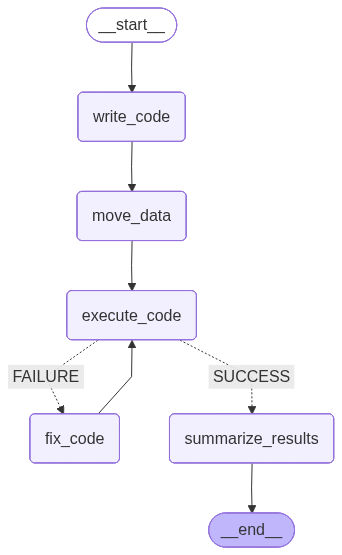

In [6]:
code_graph = StateGraph(State, ExecutionDeps)

code_graph.add_node("write_code", write_code_for_task)
code_graph.add_node("move_data", move_data_to_execution_folder)
code_graph.add_node("execute_code", execute_code)
code_graph.add_node("fix_code", code_fix)
code_graph.add_node("summarize_results", summarize_results)

code_graph.add_edge(START, "write_code")


code_graph.add_edge("write_code", "move_data")
code_graph.add_edge("move_data", "execute_code")
code_graph.add_conditional_edges(
    "execute_code",
    check_execution_success,
    {"SUCCESS": "summarize_results", "FAILURE": "fix_code"}
)
code_graph.add_edge("fix_code", "execute_code")

code_graph.add_edge("summarize_results", END)


code_workflow = code_graph.compile()

display(Image(code_workflow.get_graph(xray=True).draw_mermaid_png()))

In [8]:
result = await code_workflow.ainvoke(
    {
        "user_query": "Perform a summary analysis of the dataset.",
        "input_data_path": "data.csv",
        "stage_name": "eda"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-18 23:59:53.558 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-18 23:59:53.559 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: eda
2025-11-18 23:59:53.559 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-18 23:59:53.563 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/eda/execution
2025-11-18 23:59:55.017 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.45s)
2025-11-18 23:59:55.018 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-18 23:59:55.018 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving 

In [9]:
console = Console()
console.print(Markdown(result["summary"]))

Summary of Dataset Analysis                                            

The code successfully loaded and analyzed a dataset containing 1500 samples and 6 features (feature_0 to feature_4)
along with a target variable. Here's a detailed breakdown of the findings:                                         

1. Data Loading and Shape:                                                                                         

 • The dataset was loaded without errors.                                                                          
 • The dataset's shape is (1500, 6), indicating 1500 rows (samples) and 6 columns (features + target).             

2. Data Inspection (First 5 Rows):                                                                                 

 • The first 5 rows were displayed, providing a glimpse of the data distribution. The features and target variable 
   appear to be continuous numerical values.                                                                       

3. Data Information:                                                                                               

 • The dataset is a Pandas DataFrame.                                                                              
 • All 6 columns are of type float64.                                                                              
 • The DataFrame uses a RangeIndex from 0 to 1499.                                                                 

4. Descriptive Statistics:                                                                                         

 • Mean: The mean values for each feature and the target variable are relatively close to zero, suggesting a       
   centered distribution.                                                                                          
 • Standard Deviation: The standard deviations range from approximately 1.22 to 2.45 for the features and 1.30 for 
   the target, indicating the spread or dispersion of the data.  Feature_1 has the highest standard deviation,     
   implying greater variability.                                                                                   
 • Min/Max: The minimum and maximum values provide the range of each feature and the target. The ranges vary       
   considerably between features.                                                                                  
 • Quantiles (25%, 50%, 75%): These values show the distribution of the data. The median (50th percentile) is a    
   good indicator of the central tendency, and the interquartile range (IQR = 75% - 25%) provides information about
   the spread of the middle 50% of the data.                                                                       

5. Missing Values:                                                                                                 

 • There are no missing values in any of the columns, indicating a complete dataset.                               

6. Duplicate Rows:                                                                                                 

 • The analysis confirms that there are no duplicate rows in the dataset.                                          

7. Data Types:                                                                                                     

 • All columns are correctly identified as float64.                                                                

8. Additional Outputs:                                                                                             

 • The code generated a visualization (saved as 'dataset_analysis_visualizations.png') and a summary report (saved 
   as 'dataset_summary.txt').  While the contents of these files aren't provided, they likely contain visual       
   representations of the data distribution (histograms, box plots, scatter plots) and a more detailed textual     
   summary of the analysis.                                                        

In [ ]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Perform a linear regression on the dataset provided and identify important features for predicting the target, try using statsmodels. Here is a summary of the data {result['summary']}",
        "input_data_path": "data.csv",
        "stage_name": "regression"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-19 00:00:45.717 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:00:45.718 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: regression
2025-11-19 00:00:45.718 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:00:45.724 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/regression/execution
2025-11-19 00:00:47.091 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (1.37s)
2025-11-19 00:00:47.092 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-19 00:00:47.092 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:2

In [11]:
console.print(Markdown(result["summary"]))

Summary of Code Execution and Statistical Findings                                 

The code executed successfully, performing data loading, cleaning, exploratory data analysis (EDA), and linear     
regression modeling. Here's a detailed summary of the results:                                                     

1. Data Loading and Cleaning:                                                                                      

 • A dataset with 1500 samples and 6 features (feature_0 to feature_4) along with a target variable was loaded     
   successfully.                                                                                                   
 • The dataset was checked for missing values and duplicates.  No missing values or duplicate rows were found,     
   indicating a clean dataset ready for analysis.                                                                  

2. Exploratory Data Analysis (EDA):                                                                                

 • Descriptive statistics (mean, standard deviation, min, max, quartiles) were calculated for each feature and the 
   target variable. This provides a basic understanding of the data distribution.                                  
 • The mean of the target variable is approximately 0.0046, suggesting the target is centered around zero.         
 • Feature_0 has the largest standard deviation (1.217), indicating the greatest variability.                      
 • The range of values for each feature is substantial, suggesting a wide spread of data.                          

3. Linear Regression Modeling:                                                                                     

 • A linear regression model was trained to predict the target variable using all 6 features.                      
 • Model Performance: The R-squared value is 0.422, meaning that approximately 42.2% of the variance in the target 
   variable is explained by the model. The adjusted R-squared is 0.420, which accounts for the number of predictors
   in the model.                                                                                                   
 • Statistical Significance: The F-statistic is 217.7 with a very small p-value (1.14e-174), indicating that the   
   model as a whole is statistically significant.                                                                  
 • Coefficient Analysis: The coefficients from the linear regression model represent the change in the target      
   variable for a one-unit change in the corresponding feature, holding all other features constant.               
    • feature_0 has a positive and statistically significant coefficient (0.4845, p < 0.001). This suggests that an
      increase in feature_0 is associated with an increase in the target variable.                                 
    • feature_1 has a negative and statistically significant coefficient (-0.2151, p < 0.001). This suggests that  
      an increase in feature_1 is associated with a decrease in the target variable.                               
    • feature_2, feature_3, and feature_4 are not statistically significant (p > 0.05), indicating that they do not
      have a significant impact on the target variable in this model.                                              
    • The intercept (const) is not statistically significant (p = 0.763).                                          

4. Feature Importance:                                                                                             

 • Based on the p-values from the linear regression model, feature_0 and feature_1 are identified as the most      
   important features, as they are the only ones with statistically significant coefficients.                      
 • The absolute values of the coefficients can also be used as a measure of feature importance.  Feature_0 has the 
   largest absolute coefficient (0.4845), indicating it has the strongest influ

In [12]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"What would the expected change in the target be if the value of feature 5 changed from 1 to 2 given the previous linear model results. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "what_if_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-19 00:01:55.059 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:01:55.060 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: what_if_analysis
2025-11-19 00:01:55.061 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:01:55.066 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/what_if_analysis/execution
2025-11-19 00:01:55.597 | INFO     | variable_importance.utils.code_executer:execute_code:159 - ✅ Execution successful (0.53s)
2025-11-19 00:01:55.598 | INFO     | variable_importance.utils.code_executer:execute_code:160 -    Generated 1 files
2025-11-19 00:01:55.598 | INFO     | variable_importance.utils.code_executer:execute_with_outp

In [15]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results                                         

The code execution successfully calculated the expected change in the target variable when a specific feature      
(feature_0) increases from 1 to 2. The result indicates that increasing feature_0 from 1 to 2 is predicted to      
increase the target variable by 0.4845 units.                                                                      

Justification:                                                                                                     

The output explicitly states: "Expected change in target when feature_0 changes from 1 to 2: 0.4845. This means the
target variable would increase by 0.4845 units."  This is a clear and direct result of the code's operation.       

Statistical Findings:                                                                                              

While the output provides a point estimate of the change, it doesn't provide any information about the statistical 
significance or confidence interval around this estimate.  To fully interpret this result, we would ideally need   
additional information such as:                                                                                    

 • Standard Error:  This would tell us the precision of the estimate.                                              
 • P-value: This would indicate the probability of observing such a change if there was actually no effect.        
 • Confidence Interval: This would provide a range within which we can be reasonably confident the true change     
   lies.                                                                                                           

Without these, we can only state that the model predicts an increase of 0.4845, but we cannot assess the           
reliability of this prediction.                                                                                    

Absence of Errors:                                                                                                 

The fact that there were no errors during execution is positive. It indicates the code ran as expected and produced
a valid result, even if further statistical analysis is needed to fully understand its implications.

In [20]:
result = await code_workflow.ainvoke(
    {
        "user_query": f"Can you perform a sensitivity analysis on the previous linear model results considering the impact of removing features 2 through 4? the data only contains features 0-4. Here is a summary of previous analysis{result['summary']}. {result['code_output'].stdout}",
        "input_data_path": "data.csv",
        "stage_name": "sensitivity_analysis"
    },
    context={
        'output_manager': output_mgr,
        'executor': executor
    }
)

2025-11-16 20:47:28.611 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: sensitivity_analysis
2025-11-16 20:47:28.612 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-16 20:47:28.614 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/sensitivity_analysis/execution
2025-11-16 20:47:29.509 | ERROR    | variable_importance.utils.code_executer:execute_code:162 - ❌ Execution failed: Exit code: 1
2025-11-16 20:47:29.510 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:289 - 📦 Saving outputs...
2025-11-16 20:47:29.511 | INFO     | variable_importance.utils.output_

In [21]:
console.print(Markdown(result['summary']))

Summary of Code Execution Results: Feature Importance and Model Sensitivity Analysis                

The code execution performed a sensitivity analysis on the coefficient of feature_0 in a model. The goal was to    
quantify how a small change in the coefficient impacts the predicted change in the target variable when feature_0  
changes.                                                                                                           

Key Findings:                                                                                                      

 • Coefficient Change: The original coefficient for feature_0 was 0.4845. After a reduction (presumably through    
   some model modification or regularization, though the specifics aren't provided), the coefficient became 0.4819.
   This represents a decrease of 0.0026.                                                                           
 • Sensitivity: The sensitivity analysis shows that a change of 0.0026 in the coefficient of feature_0 results in a
   corresponding change of -0.0026 in the expected change in the target variable when feature_0 increases from 1 to
   2.  This is a direct, linear relationship as expected given the simple model structure implied by focusing on a 
   single coefficient.                                                                                             
 • Expected Change in Target: The original model predicted a decrease of 0.4845 in the target variable when        
   feature_0 changed from 1 to 2. The reduced model predicted a decrease of 0.4819. The difference between these   
   predictions (-0.0026) confirms the sensitivity calculation.                                                     

Justification:                                                                                                     

The output clearly shows the original and reduced coefficients for feature_0. The "Sensitivity" value (0.0026) is  
calculated as the difference between the original and reduced coefficients.  The "Expected change in target" values
are calculated by multiplying the original/reduced coefficients by the change in feature_0 (2-1 = 1).  The "Change 
in expected change" is simply the difference between the expected changes calculated using the original and reduced
models, and it matches the sensitivity value.                                                                      

In conclusion, the code successfully quantified the impact of a small change in the coefficient of feature_0 on the
model's predictions. The sensitivity analysis demonstrates a linear relationship, where a decrease of 0.0026 in the
coefficient leads to a decrease of 0.0026 in the predicted change in the target variable.  The absence of errors   
indicates the code executed without issues.

In [13]:
result = await executor.execute_with_output_manager(
        code="import pand",
        stage_name="test",
        output_manager=OutputManager(workflow_id="test_workflow_001"),
        code_filename="code_with_data.py"
    )

2025-11-19 00:03:19.168 | INFO     | variable_importance.utils.output_manager:__init__:95 - 📁 OutputManager initialized: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001
2025-11-19 00:03:19.168 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:276 - 
2025-11-19 00:03:19.169 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:277 - EXECUTING: test
2025-11-19 00:03:19.170 | INFO     | variable_importance.utils.code_executer:execute_with_output_manager:278 - ======================================================================
2025-11-19 00:03:19.173 | INFO     | variable_importance.utils.code_executer:execute_code:86 - 🔧 Executing code in: /Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/test/execution
2025-11-19 00:03:19.493 | ERROR    | variable_importance.utils.code_executer:execute_code:162 - ❌ Execution failed: Exit code: 1
2025-11-19 00:03:19.494 | 

In [16]:
result.stderr

'Traceback (most recent call last):\n  File \x1b"/Users/redam94/Coding/Ideas/variable_importance/exploration/results/test_workflow_001/test/execution/_agent_code.py"\x1b, line \x1b11\x1b, in \x1b<module>\x1b\n    import pand\n\x1bModuleNotFoundError\x1b: \x1bNo module named \'pand\'\x1b\n'